<a href="https://colab.research.google.com/github/SergeiVKalinin/BO_Research/blob/master/noisyBO_1D_GPax_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BO with noise measurements**
Dec, 2023

Tutorial for BO with GP predicts function and the respective noise, implemented in Gpax

-- Notebook prepared by **Arpan Biswas**

-- Gpax developed by **Maxim Ziatdinov**





In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git
!pip install mycolorpy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=1f4ea424a4f78c1b128a8547aed30c5f33ca481c15255584bc482bdbbd52f95b
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
import jax.random as jra
from gpax.kernels import RBFKernel

import jax
import jaxlib
import numpyro
import numpyro.distributions as dist

from gpax.models import ExactGP
from mycolorpy import colorlist as mcp

from sklearn.model_selection import train_test_split
from typing import Callable, Dict, Optional, Tuple, Type, Union
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive

import warnings

from gpax.kernels import get_kernel

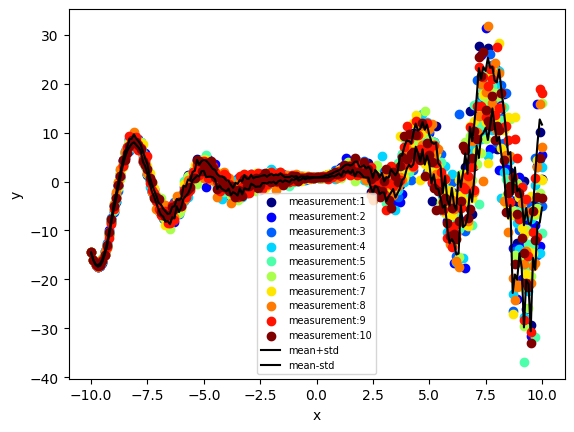

In [ ]:
def objective(x,lb,ub):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * np.sin(2 * x + 2) / 5 + 1 + x / 3 + ((x-lb)/(ub-lb))*np.random.normal(0, np.absolute(x), x.shape)
    return y

lb = -10
ub = 10

bounds = np.array((lb, ub), dtype=float)

xs = np.linspace(lb, ub, 201)
xs_norm = (xs-lb)/(ub-lb)
n_measurement= 10

np.random.seed(1)
ys = np.zeros((xs.shape[0], n_measurement))
for i in range(n_measurement):
  ys[:, i] = objective(xs, lb, ub)

color=mcp.gen_color(cmap="jet",n=n_measurement)
for i in range(n_measurement):
  plt.scatter(xs, ys[:, i], c=color[i], label="measurement:"+str(i+1))

plt.plot(xs, ys.mean(axis=1)+ys.std(axis=1), c="k", label="mean+std")
plt.plot(xs, ys.mean(axis=1)-ys.std(axis=1), c="k", label="mean-std")
plt.legend(loc="best", fontsize=7)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Here, the noise increases from left to right

#GP model adapted from GPax

- Here, the GP predicts noisy function where the user provided measured noise data (from multiple measurements)

- We predict the noise of the location from linear regression model, which can be extended to more complex models in future.

In [ ]:
kernel_fn_type = Callable[[jnp.ndarray, jnp.ndarray, Dict[str, jnp.ndarray], jnp.ndarray], jnp.ndarray]

clear_cache = jax._src.dispatch.xla_primitive_callable.cache_clear

class MeasuredNoiseGP(ExactGP):


    def __init__(
        self,
        input_dim: int,
        kernel: Union[str, kernel_fn_type],
        mean_fn: Optional[Callable[[jnp.ndarray, Dict[str, jnp.ndarray]], jnp.ndarray]] = None,
        kernel_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
        mean_fn_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
        noise_prior: Optional[Callable[[], Dict[str, jnp.ndarray]]] = None,
        noise_prior_dist: Optional[dist.Distribution] = None,
        lengthscale_prior_dist: Optional[dist.Distribution] = None,
    ) -> None:
        clear_cache()
        if noise_prior is not None:
            warnings.warn(
                "`noise_prior` is deprecated and will be removed in a future version. "
                "Please use `noise_prior_dist` instead, which accepts an instance of a "
                "numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, "
                "rather than a function that calls `numpyro.sample`.",
                FutureWarning,
            )
        if kernel_prior is not None:
            warnings.warn(
                "`kernel_prior` will remain available for complex priors. However, for "
                "modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. "
                "`lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, "
                "e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.",
                UserWarning,
            )
        self.kernel_dim = input_dim
        self.kernel = get_kernel(kernel)
        self.kernel_name = kernel if isinstance(kernel, str) else None
        self.mean_fn = mean_fn
        self.kernel_prior = kernel_prior
        self.mean_fn_prior = mean_fn_prior
        self.noise_prior = noise_prior
        self.noise_prior_dist = noise_prior_dist
        self.lengthscale_prior_dist = lengthscale_prior_dist
        self.X_train = None
        self.y_train = None
        self.mcmc = None

    def model(self, X, y=None, measured_noise=None, **kwargs: float):

        # Standard GP kernel computation, but without sampling noise, i.e. noise = numpyro.deterministic("noise", jnp.array(0))
        # ...

        # Initialize mean function at zeros
        f_loc = jnp.zeros(X.shape[0])
        # Sample kernel parameters
        if self.kernel_prior:
            kernel_params = self.kernel_prior()
        else:
            kernel_params = self._sample_kernel_params()

        # Add noise if needed
        if measured_noise is None:
          if self.noise_prior:  # this will be removed in the future releases
              noise = self.noise_prior()
          else:
              noise = self._sample_noise()
        else:
          noise = numpyro.deterministic("noise", jnp.array(0))
        # Add mean function (if any)
        if self.mean_fn is not None:
            args = [X]
            if self.mean_fn_prior is not None:
                args += [self.mean_fn_prior()]
            f_loc += self.mean_fn(*args).squeeze()
        # compute kernel
        k = self.kernel(X, X, kernel_params, noise, **kwargs)

        if measured_noise is None: # Noise is sampled like standard GP
          numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )
        else: # Adding option of NOT sampling noise when noise is measured externally from data
          numpyro.sample(
              "y",
              dist.MultivariateNormal(loc=f_loc, covariance_matrix=k+jnp.diag(measured_noise)),
              obs=y,
          )


    def fit(
        self,
        rng_key: jnp.array,
        X: jnp.ndarray,
        y: jnp.ndarray,
        measured_noise=None,
        num_warmup: int = 2000,
        num_samples: int = 2000,
        num_chains: int = 1,
        chain_method: str = "sequential",
        progress_bar: bool = True,
        print_summary: bool = True,
        device: Type[jaxlib.xla_extension.Device] = None,
        **kwargs: float
    ) -> None:
        """
        Run Hamiltonian Monter Carlo to infer the GP parameters

        Args:
            rng_key: random number generator key
            X: 2D feature vector
            y: 1D target vector
            num_warmup: number of HMC warmup states
            num_samples: number of HMC samples
            num_chains: number of HMC chains
            chain_method: 'sequential', 'parallel' or 'vectorized'
            progress_bar: show progress bar
            print_summary: print summary at the end of sampling
            device:
                optionally specify a cpu or gpu device on which to run the inference;
                e.g., ``device=jax.devices("cpu")[0]``
            **jitter:
                Small positive term added to the diagonal part of a covariance
                matrix for numerical stability (Default: 1e-6)
        """
        X, y = self._set_data(X, y)
        if device:
            X = jax.device_put(X, device)
            y = jax.device_put(y, device)
        self.X_train = X
        self.y_train = y

        init_strategy = init_to_median(num_samples=10)
        kernel = NUTS(self.model, init_strategy=init_strategy)
        self.mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_samples,
            num_chains=num_chains,
            chain_method=chain_method,
            progress_bar=progress_bar,
            jit_model_args=False,
        )
        self.mcmc.run(rng_key, X, y, measured_noise, **kwargs)
        if print_summary:
            self._print_summary()

    def _predict(self, rng_key, X_new, params, predicted_noise, n, noiseless, **kwargs):
        # Get the predictive mean and covariance
        plt.plot(jnp.array(predicted_noise))
        plt.show()
        y_mean, K = self.get_mvn_posterior(X_new, params, noiseless, **kwargs)
        # Add predicted noise
        K += jnp.diag(predicted_noise)
        # draw samples from the posterior predictive for a given set of parameters
        y_sampled = dist.MultivariateNormal(y_mean, K).sample(rng_key, sample_shape=(n,))
        return y_mean, y_sampled


    def predict(self, rng_key, X_new, X_train, measured_noise, samples=None, n=1,
                filter_nans: bool = False, noiseless: bool = False,device: Type[jaxlib.xla_extension.Device] = None,*args, **kwargs):
        # Perform linear regression to obtain noise values for X_new given measured noise values
        # ...
        # Calculate variance/noise of the measured samples
        #noise_train = jnp.power(jnp.std(Y_train, axis =1),2)
        #noise_train = noise_train*10
        noise_train = measured_noise
        # Split into test train dataset for LR
        # X, X_test, y, y_test = train_test_split(X_train, noise_train)


        # model weights
        params = {
            'w': jnp.zeros(X_train.shape[1:]),
            'b': 0.
        }


        grad_fn = jax.grad(self.loss_fn)
        lr = 0.005
        n_iter = 500

        # the main training loop
        for i in range(n_iter):
            loss = self.loss_fn(params, X_train, noise_train)
            if i%100 == 0:
              print("loss for iter:" +str(i) +"=" +str(loss))
            grads = grad_fn(params, X_train, noise_train)
            params = self.update(params, lr, grads)

        # Predict noise values for new locations
        predicted_noise = self.forward(params, X_new)
        # Constraining the LR model >=0
        predicted_noise = predicted_noise.at[predicted_noise < 0].set(0)


        # Standard GP prediction via self._predict method (pass the predicted noise to it)
        X_new = self._set_data(X_new)
        if samples is None:
            samples = self.get_samples(chain_dim=False)
        if device:
            self._set_training_data(device=device)
            X_new = jax.device_put(X_new, device)
            samples = jax.device_put(samples, device)
        num_samples = len(next(iter(samples.values())))
        vmap_args = (jra.split(rng_key, num_samples), samples)
        predictive = jax.vmap(lambda prms: self._predict(prms[0], X_new, prms[1], predicted_noise, n, noiseless, **kwargs))
        y_means, y_sampled = predictive(vmap_args)
        if filter_nans:
            y_sampled_ = [y_i for y_i in y_sampled if not jnp.isnan(y_i).any()]
            y_sampled = jnp.array(y_sampled_)

        return y_means.mean(0), y_sampled


    def forward(self,params, X):
        return jnp.dot(X, params['w']) + params['b']


    def loss_fn(self,params, X, y):
        err = self.forward(params, X) - y
        return jnp.mean(jnp.square(err))  # mse

    def update(self,params, lr, grads):
        return jax.tree_map(lambda p, g: p - lr * g, params, grads)


# Standard Bayesian Optimization - with single measurements only (ignoring noise measurements)

In [ ]:
n = 10

np.random.seed(1)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_x, train_x_norm

(array([[-1.65955991],
        [ 4.40648987],
        [-9.9977125 ],
        [-3.95334855],
        [-7.06488218],
        [-8.1532281 ],
        [-6.27479577],
        [-3.08878546],
        [-2.06465052],
        [ 0.77633468]]),
 array([[4.17022005e-01],
        [7.20324493e-01],
        [1.14374817e-04],
        [3.02332573e-01],
        [1.46755891e-01],
        [9.23385948e-02],
        [1.86260211e-01],
        [3.45560727e-01],
        [3.96767474e-01],
        [5.38816734e-01]]))

In [ ]:
n_measurement= 10 #Number of measurements per locations

np.random.seed(10)
train_y = np.zeros((train_x.shape[0], n_measurement))
for i in range(n_measurement):
  t_y = objective(train_x, lb, ub)
  train_y[:, i] = t_y[:, 0]

train_y

array([[  1.45263134,   0.83076201,  -0.83765607,   0.34607327,
          0.9880047 ,   0.51314789,   0.3703892 ,   0.75209423,
          1.90489972,   1.29769123],
       [ 10.48804029,  12.03623549,   2.68402895,   6.47410829,
          7.10396808,   9.13528611,   6.62513246,   9.68062454,
         13.75589055,   8.99387912],
       [-14.54293479, -14.54227118, -14.54086339, -14.54101589,
        -14.54224187, -14.54178499, -14.53987689, -14.5414144 ,
        -14.54329017, -14.54123844],
       [ -0.96916385,   0.2698767 ,   1.8914318 ,  -1.52824059,
         -1.54401184,  -0.11273196,  -1.79318397,   0.2230219 ,
         -1.22540818,  -1.86021575],
       [ -3.821594  ,  -4.22875656,  -3.30074548,  -3.10916126,
         -5.30001389,  -3.59257364,  -4.54991181,  -4.13946243,
         -4.53407518,  -3.72763485],
       [  7.82757618,   8.70482333,   9.62894447,   8.51651532,
          8.20956705,   8.52296544,   7.97121349,  10.227488  ,
          6.76482237,   9.06102402],
       [ -

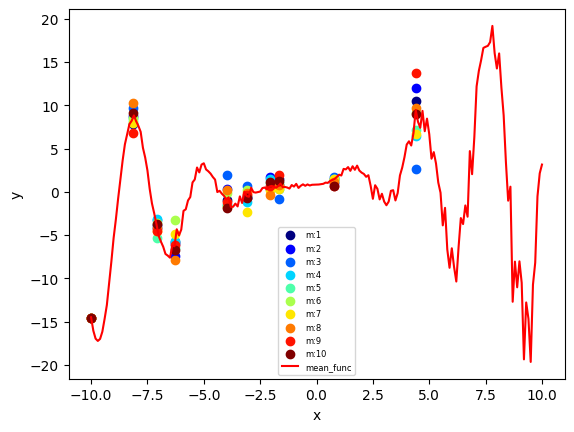

In [ ]:
color=mcp.gen_color(cmap="jet",n=n_measurement)
for i in range(n_measurement):
  plt.scatter(train_x, train_y[:, i], c=color[i], label="m:"+str(i+1))

plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
plt.legend(loc="best", fontsize=6)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# For this analysis, we consider only the 1st measurement in BO (ignoring multiple measurements of noisy functions)

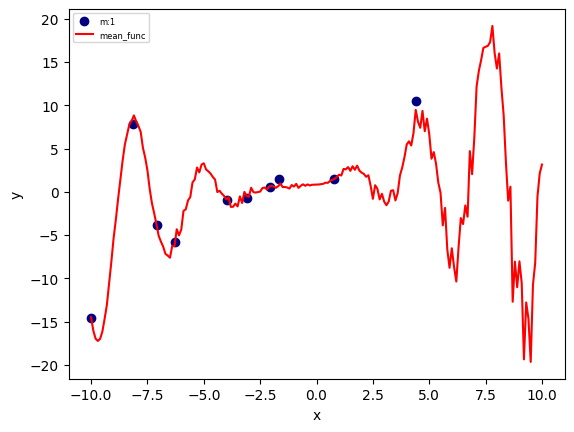

In [ ]:
plt.scatter(train_x, train_y[:, 0], c=color[0], label="m:"+str(1))

plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
plt.legend(loc="best", fontsize=6)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
train_y1 = train_y[:, 0]

Step:1


sample: 100%|██████████| 4000/4000 [00:06<00:00, 659.58it/s, 3 steps of size 1.97e-01. acc. prob=0.93]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.09      1.27      0.71      0.02      2.36    510.97      1.00
    k_scale     12.92     14.82      4.07      0.05     34.49    133.27      1.01
      noise     16.66     14.93     17.06      0.06     35.65    138.71      1.01



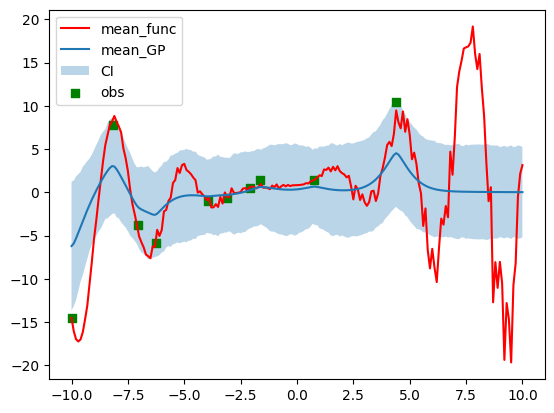

Step:2


sample: 100%|██████████| 4000/4000 [00:06<00:00, 650.75it/s, 15 steps of size 2.86e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.70      0.92      0.61      0.13      1.06    745.75      1.00
    k_scale     23.64     12.98     23.05      0.08     39.09    300.19      1.00
      noise      5.66      9.42      1.81      0.18     19.72    107.17      1.00



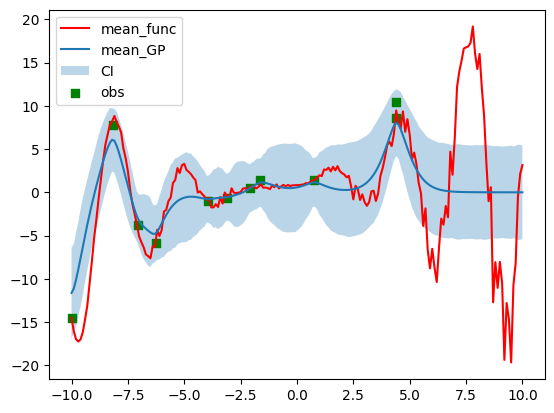

Step:3


sample: 100%|██████████| 4000/4000 [00:06<00:00, 642.30it/s, 7 steps of size 3.85e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.13      1.66      0.64      0.03      2.53    622.15      1.00
    k_scale      8.00     10.39      2.90      0.02     23.11    342.28      1.00
      noise     20.24     12.60     19.71      0.49     36.54    465.01      1.00



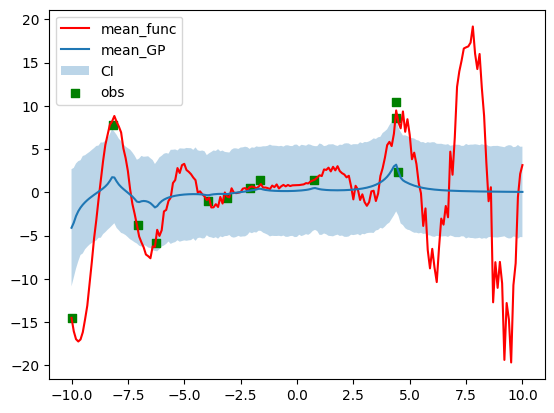

Step:4


sample: 100%|██████████| 4000/4000 [00:06<00:00, 624.09it/s, 11 steps of size 3.56e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.01      1.27      0.64      0.03      2.26    813.20      1.00
    k_scale      8.95      9.78      5.02      0.04     22.45    441.45      1.00
      noise     17.97     11.51     16.71      2.11     33.41    452.61      1.00



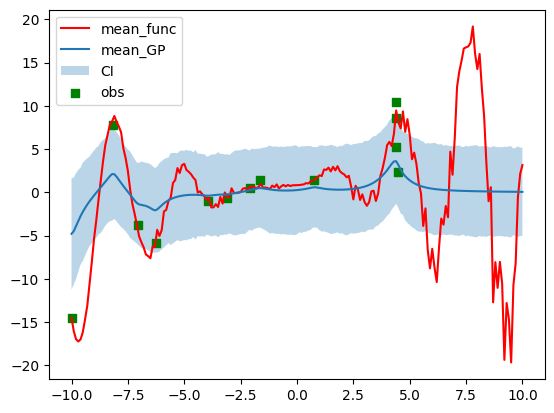

Step:5


sample: 100%|██████████| 4000/4000 [00:06<00:00, 626.73it/s, 15 steps of size 3.38e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.81      0.97      0.55      0.06      1.53    458.15      1.00
    k_scale     14.61     11.60     13.14      0.09     29.67    533.25      1.00
      noise     12.83     11.00      8.84      1.54     28.62    333.52      1.00



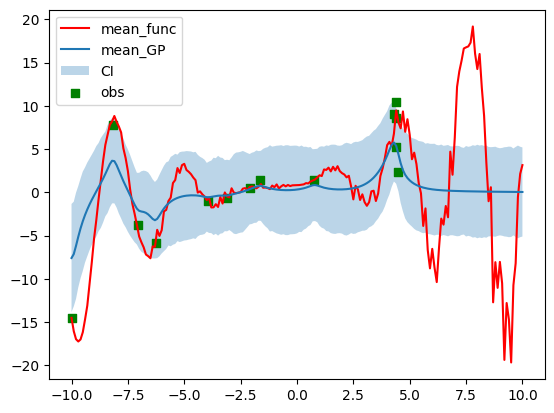

Step:6


sample: 100%|██████████| 4000/4000 [00:06<00:00, 604.32it/s, 7 steps of size 3.80e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.67      0.71      0.52      0.10      1.13    654.66      1.00
    k_scale     16.18     10.20     15.22      0.14     29.06    595.34      1.00
      noise      9.91      8.50      6.90      1.52     21.69    376.83      1.00



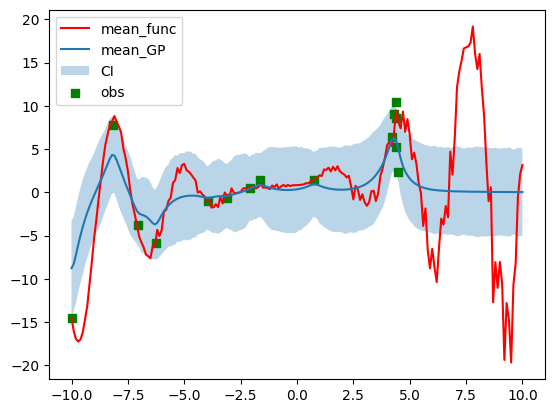

Step:7


sample: 100%|██████████| 4000/4000 [00:06<00:00, 662.71it/s, 7 steps of size 4.65e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.63      0.56      0.53      0.12      1.01    643.61      1.00
    k_scale     17.76      9.87     16.13      0.66     30.29   1095.49      1.00
      noise      7.77      6.15      5.98      1.63     14.92    510.80      1.00



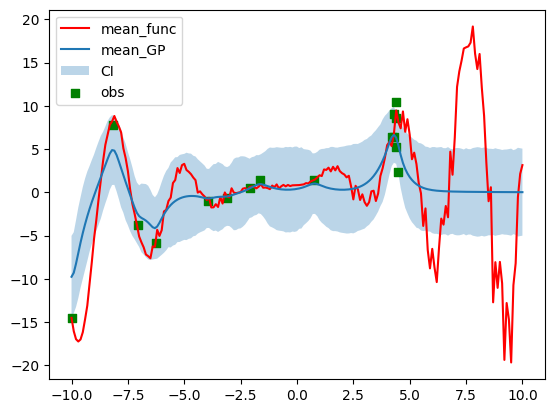

Step:8


sample: 100%|██████████| 4000/4000 [00:08<00:00, 492.85it/s, 7 steps of size 4.41e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.58      0.49      0.53      0.12      0.94    792.82      1.00
    k_scale     19.34     10.14     17.40      6.04     35.65   1166.51      1.00
      noise      6.32      4.47      5.04      1.36     11.48    570.94      1.00



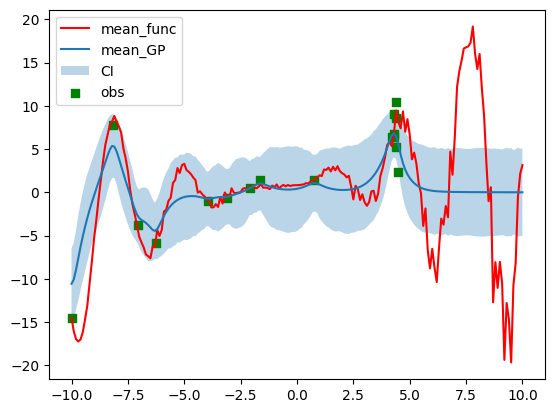

Step:9


sample: 100%|██████████| 4000/4000 [00:06<00:00, 618.04it/s, 15 steps of size 5.58e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.66      0.42      0.61      0.16      1.00    390.02      1.00
    k_scale     19.95     10.21     17.93      5.92     36.42    881.49      1.00
      noise      5.80      3.59      4.76      1.55      9.91    565.44      1.00



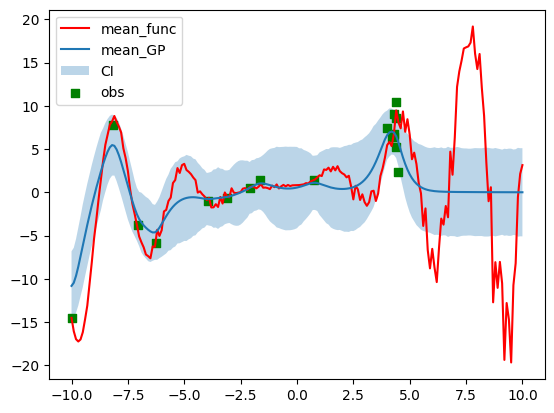

Step:10


sample: 100%|██████████| 4000/4000 [00:06<00:00, 625.45it/s, 7 steps of size 6.05e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.63      0.26      0.61      0.23      0.99   1085.13      1.00
    k_scale     20.73      9.79     18.57      6.96     34.81    979.56      1.00
      noise      5.00      2.74      4.31      1.87      8.47    861.61      1.00



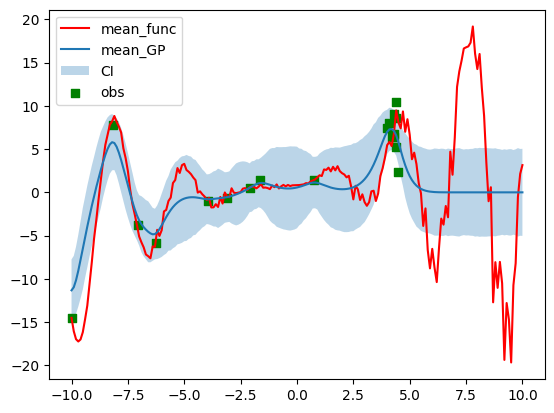

Step:11


sample: 100%|██████████| 4000/4000 [00:06<00:00, 624.29it/s, 7 steps of size 4.99e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.51      0.26      0.46      0.14      0.82    960.90      1.00
    k_scale     18.96      8.91     17.43      7.12     33.89   1144.69      1.00
      noise      5.65      3.34      4.79      1.53      9.72    717.46      1.00



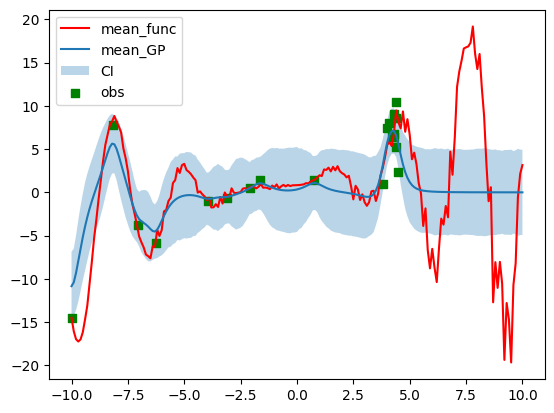

Step:12


sample: 100%|██████████| 4000/4000 [00:06<00:00, 590.40it/s, 7 steps of size 6.47e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.48      0.21      0.45      0.14      0.77   1402.29      1.00
    k_scale     20.09      9.30     18.04      8.04     34.76   1406.01      1.00
      noise      4.83      2.55      4.22      1.59      8.15   1213.58      1.00



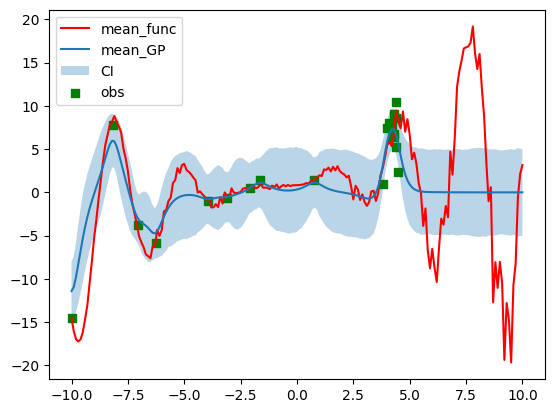

Step:13


sample: 100%|██████████| 4000/4000 [00:06<00:00, 601.17it/s, 7 steps of size 5.70e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.49      0.19      0.46      0.19      0.78   1642.67      1.00
    k_scale     20.82      9.11     18.83      8.41     33.37   1370.79      1.00
      noise      4.42      2.09      3.98      1.71      7.18   1518.03      1.00



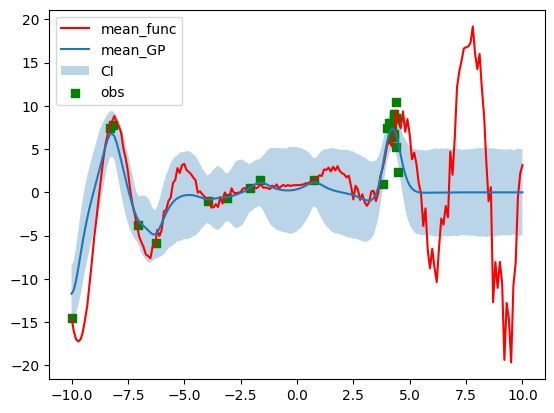

Step:14


sample: 100%|██████████| 4000/4000 [00:06<00:00, 582.02it/s, 7 steps of size 5.37e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.18      0.44      0.17      0.73   1875.00      1.00
    k_scale     21.65      8.72     20.20      9.59     33.67   1667.58      1.00
      noise      4.17      1.86      3.78      1.67      6.59   1605.93      1.00



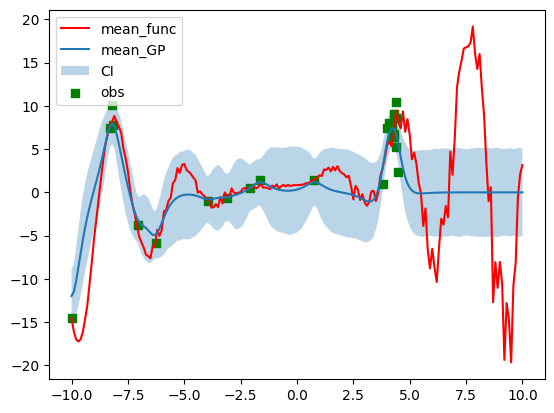

Step:15


sample: 100%|██████████| 4000/4000 [00:06<00:00, 606.58it/s, 7 steps of size 5.58e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.47      0.18      0.44      0.16      0.72   1720.80      1.00
    k_scale     22.03      8.94     20.34      9.46     34.30   1674.76      1.00
      noise      3.89      1.66      3.58      1.66      6.25   1671.76      1.00



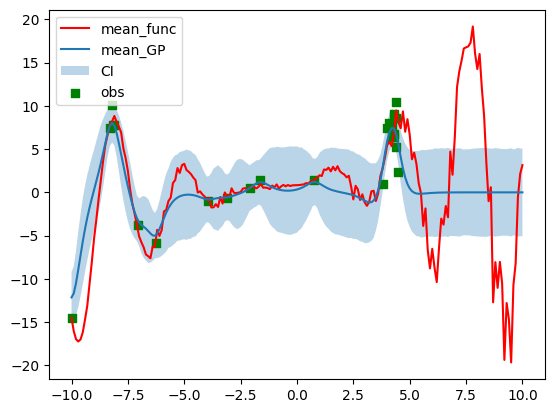

Step:16


sample: 100%|██████████| 4000/4000 [00:08<00:00, 472.12it/s, 7 steps of size 5.53e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.17      0.44      0.18      0.73   1781.36      1.00
    k_scale     22.34      8.82     20.71     10.41     34.98   1438.28      1.00
      noise      3.61      1.49      3.33      1.50      5.66   1621.13      1.00



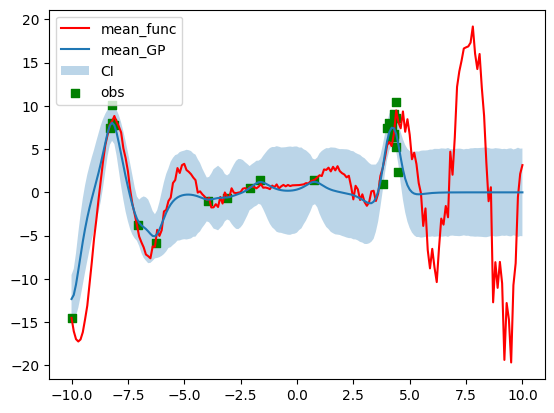

Step:17


sample: 100%|██████████| 4000/4000 [00:06<00:00, 574.21it/s, 7 steps of size 5.90e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.17      0.44      0.16      0.69   1697.94      1.00
    k_scale     22.27      8.71     20.63      9.07     34.00   1536.17      1.00
      noise      3.37      1.32      3.14      1.54      5.14   1495.78      1.00



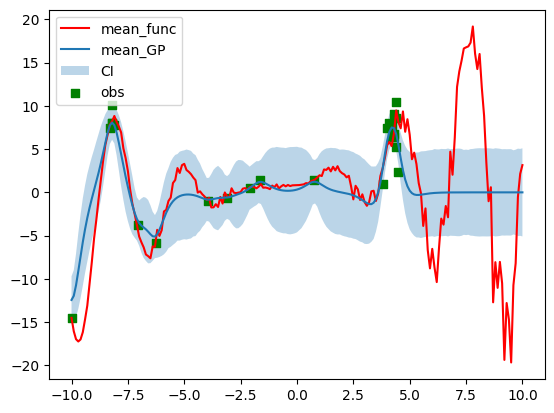

Step:18


sample: 100%|██████████| 4000/4000 [00:07<00:00, 564.36it/s, 7 steps of size 5.69e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.16      0.44      0.20      0.70   1797.74      1.00
    k_scale     22.34      9.02     20.57      9.58     34.25   1532.93      1.00
      noise      3.21      1.19      3.02      1.45      4.87   1788.62      1.00



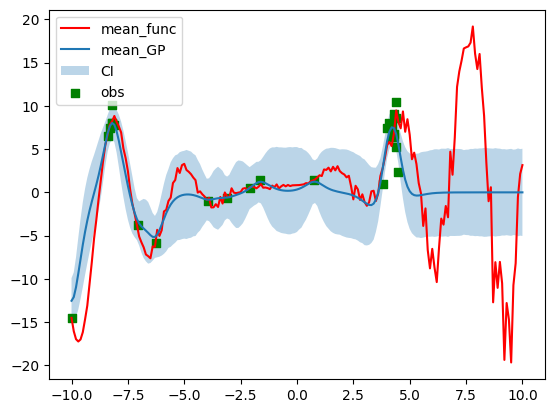

Step:19


sample: 100%|██████████| 4000/4000 [00:06<00:00, 581.85it/s, 7 steps of size 5.96e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.47      0.16      0.44      0.21      0.71   1864.01      1.00
    k_scale     22.46      8.75     20.74     10.51     35.18   1561.70      1.00
      noise      3.07      1.16      2.86      1.46      4.71   1645.47      1.00



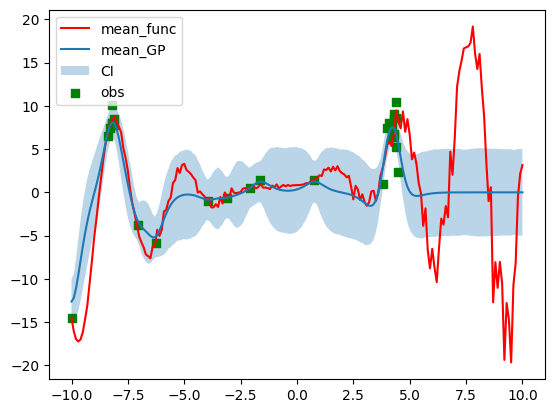

Step:20


sample: 100%|██████████| 4000/4000 [00:07<00:00, 558.75it/s, 7 steps of size 6.73e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.15      0.44      0.21      0.70   1538.05      1.00
    k_scale     22.75      9.09     21.00      9.75     35.29   1321.04      1.00
      noise      2.88      1.06      2.70      1.33      4.27   1610.86      1.00



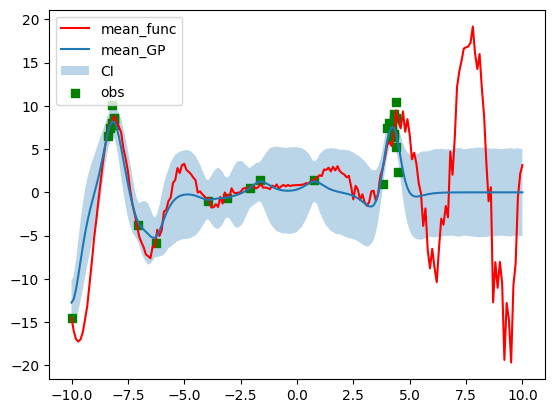

Step:21


sample: 100%|██████████| 4000/4000 [00:07<00:00, 530.14it/s, 7 steps of size 6.49e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.15      0.44      0.21      0.70   1636.60      1.00
    k_scale     22.95      9.12     21.00      9.87     35.59   1510.65      1.00
      noise      2.80      1.04      2.61      1.37      4.32   1399.30      1.00



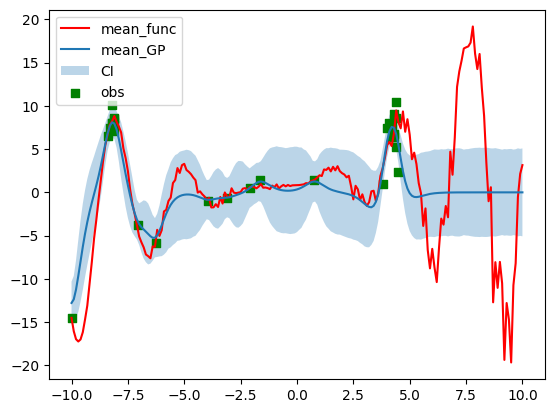

Step:22


sample: 100%|██████████| 4000/4000 [00:07<00:00, 540.26it/s, 7 steps of size 6.48e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.15      0.44      0.21      0.71   1370.39      1.00
    k_scale     23.07      9.14     21.15      9.93     35.52   1392.88      1.00
      noise      2.64      0.96      2.47      1.21      3.92   1432.95      1.00



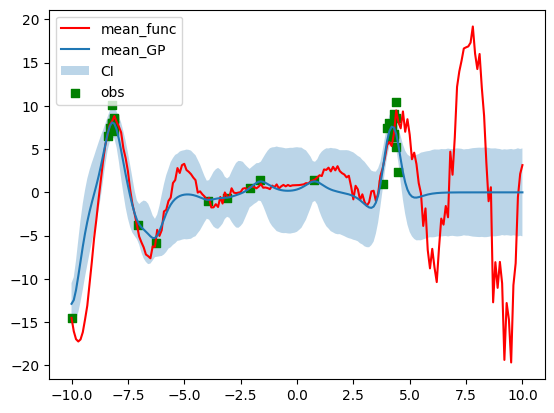

Step:23


sample: 100%|██████████| 4000/4000 [00:12<00:00, 328.11it/s, 7 steps of size 6.18e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.15      0.44      0.23      0.69   1614.91      1.00
    k_scale     23.31      9.12     21.43     10.74     35.95   1191.64      1.00
      noise      2.54      0.88      2.39      1.31      3.83   1593.32      1.00



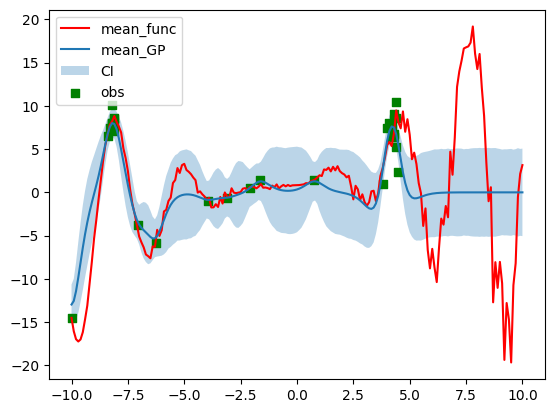

Step:24


sample: 100%|██████████| 4000/4000 [00:15<00:00, 264.81it/s, 7 steps of size 6.42e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.46      0.15      0.44      0.21      0.68   1650.96      1.00
    k_scale     23.36      9.21     21.44     10.68     36.38   1431.16      1.00
      noise      2.48      0.85      2.33      1.15      3.58   1697.46      1.00



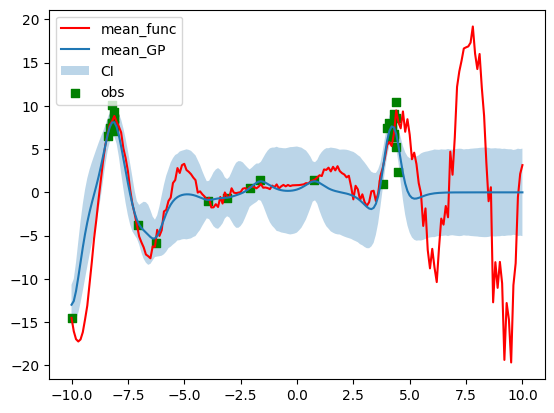

Step:25


sample: 100%|██████████| 4000/4000 [00:14<00:00, 278.99it/s, 7 steps of size 6.14e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.47      0.14      0.46      0.27      0.71   1693.26      1.00
    k_scale     24.04      9.40     22.15     11.16     37.38   1448.99      1.00
      noise      2.50      0.83      2.36      1.41      3.74   1528.37      1.00



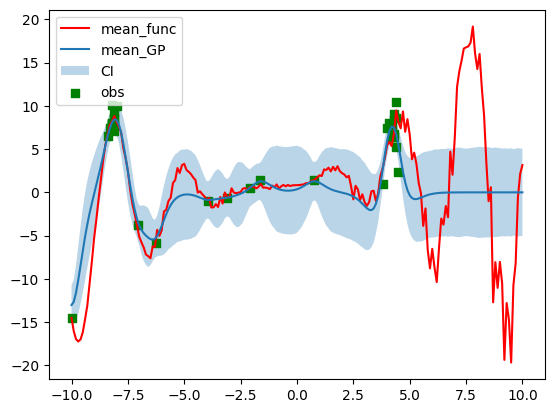

In [ ]:
N = 25
X_test =xs
X_test_full = xs

# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

for i in range(1, N+1):
    print("Step:"+str(i))


    # Initialize MF model
    gp_model = gpax.ExactGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_y1)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)
        plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        plt.plot(xs, y_pred, label="mean_GP")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI",
        )
        plt.scatter(train_x, train_y1, c="g", marker="s", label="obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    next_point_idx = acq.argmax()
    next_point_val = acq.max()
    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        t_y = objective(train_x[-1], lb, ub)
        train_y1 = np.hstack((train_y1, t_y))


Here, the standard GP is slow and generally stuck on same region due to noisy function.

# Noised measured Bayesian Optimization

Initial Sampling- 10 samples

In [ ]:
n = 10

np.random.seed(1)
train_x = bounds[0] + (bounds[1] - bounds[0]) * np.random.rand(n, 1)
train_x_norm = (train_x-bounds[0])/(bounds[1]-bounds[0])
train_x, train_x_norm

(array([[-1.65955991],
        [ 4.40648987],
        [-9.9977125 ],
        [-3.95334855],
        [-7.06488218],
        [-8.1532281 ],
        [-6.27479577],
        [-3.08878546],
        [-2.06465052],
        [ 0.77633468]]),
 array([[4.17022005e-01],
        [7.20324493e-01],
        [1.14374817e-04],
        [3.02332573e-01],
        [1.46755891e-01],
        [9.23385948e-02],
        [1.86260211e-01],
        [3.45560727e-01],
        [3.96767474e-01],
        [5.38816734e-01]]))

In [ ]:
n_measurement= 10 #Number of measurements per locations

np.random.seed(10)
train_y = np.zeros((train_x.shape[0], n_measurement))
for i in range(n_measurement):
  t_y = objective(train_x, lb, ub)
  train_y[:, i] = t_y[:, 0]

train_y

array([[  1.45263134,   0.83076201,  -0.83765607,   0.34607327,
          0.9880047 ,   0.51314789,   0.3703892 ,   0.75209423,
          1.90489972,   1.29769123],
       [ 10.48804029,  12.03623549,   2.68402895,   6.47410829,
          7.10396808,   9.13528611,   6.62513246,   9.68062454,
         13.75589055,   8.99387912],
       [-14.54293479, -14.54227118, -14.54086339, -14.54101589,
        -14.54224187, -14.54178499, -14.53987689, -14.5414144 ,
        -14.54329017, -14.54123844],
       [ -0.96916385,   0.2698767 ,   1.8914318 ,  -1.52824059,
         -1.54401184,  -0.11273196,  -1.79318397,   0.2230219 ,
         -1.22540818,  -1.86021575],
       [ -3.821594  ,  -4.22875656,  -3.30074548,  -3.10916126,
         -5.30001389,  -3.59257364,  -4.54991181,  -4.13946243,
         -4.53407518,  -3.72763485],
       [  7.82757618,   8.70482333,   9.62894447,   8.51651532,
          8.20956705,   8.52296544,   7.97121349,  10.227488  ,
          6.76482237,   9.06102402],
       [ -

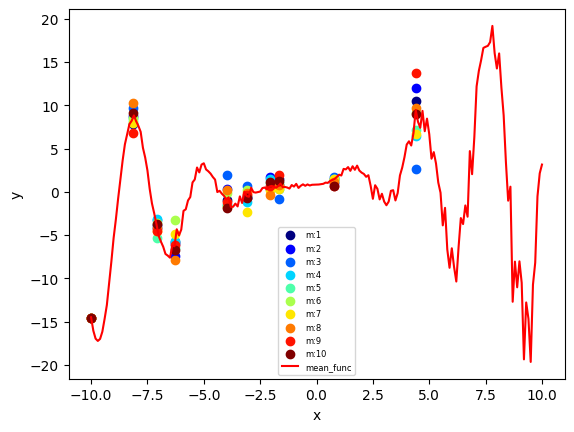

In [ ]:
color=mcp.gen_color(cmap="jet",n=n_measurement)
for i in range(n_measurement):
  plt.scatter(train_x, train_y[:, i], c=color[i], label="m:"+str(i+1))

plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
plt.legend(loc="best", fontsize=6)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
train_ym = np.mean(train_y, axis=1)
train_ym

array([  0.76180375,   8.69771939, -14.5416932 ,  -0.66486257,
        -4.03039291,   8.54349397,  -6.03126102,  -0.54354007,
         0.71403617,   1.22853232])

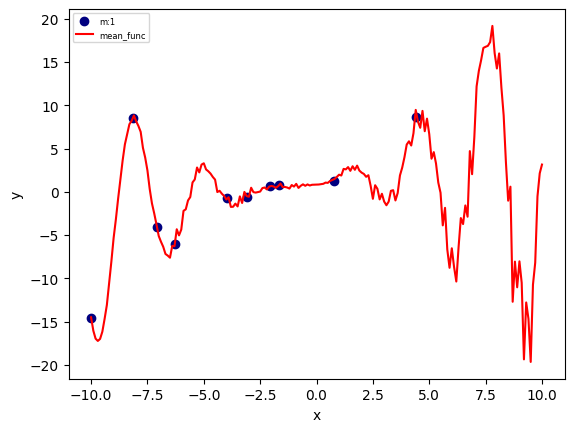

In [ ]:
plt.scatter(train_x, train_ym, c=color[0], label="m:"+str(1))

plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
plt.legend(loc="best", fontsize=6)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# GP fit -single iteration

sample: 100%|██████████| 4000/4000 [00:06<00:00, 630.52it/s, 7 steps of size 4.91e-01. acc. prob=0.82] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.56      0.23      0.56      0.16      0.91    490.42      1.00
    k_scale     27.38     10.47     25.26     12.64     41.38    620.21      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan

loss for iter:0=8.49946124711387
loss for iter:100=5.408622484607953
loss for iter:200=4.384255852968534
loss for iter:300=4.041266097717657
loss for iter:400=3.9264224776958105


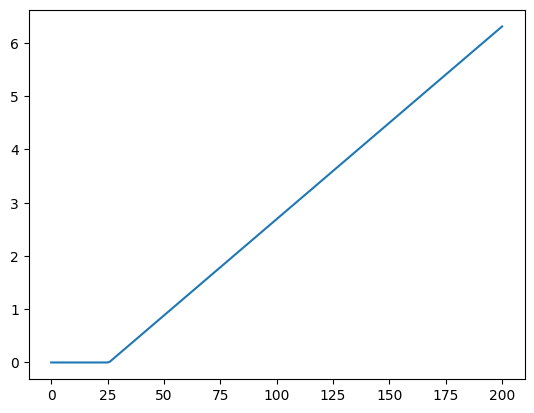

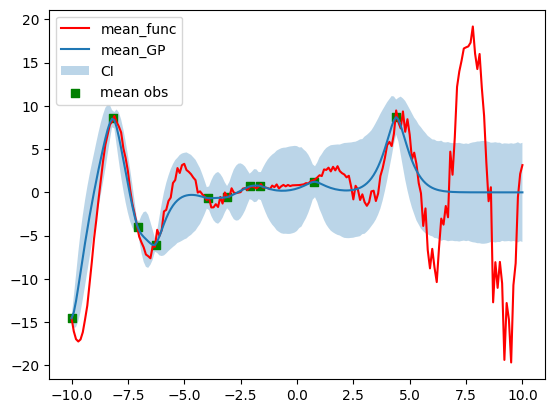

In [ ]:
X_test =xs
X_test = np.reshape(X_test,(X_test.shape[0],1))
X_test_full = xs
X_test_full = np.reshape(X_test_full,(X_test_full.shape[0],1))
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Calculate mean values of the measured samples
train_ym = np.mean(train_y, axis=1)
# Calculate noise of the measured samples
train_noise = np.absolute(np.std(train_y, axis =1))**2
train_noise = train_noise*1 #Scalling to validate (Dont need for real implementation)
# Initialize MF model
gp_model = MeasuredNoiseGP(1, kernel='RBF')
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_ym, train_noise)



y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, train_x, train_noise)
plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(xs, y_pred, label="mean_GP")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
plt.scatter(train_x, train_ym, c="g", marker="s", label="mean obs")

plt.legend(loc="best")
plt.show()

Scaled the noise by factor of 10

sample: 100%|██████████| 4000/4000 [00:06<00:00, 611.88it/s, 7 steps of size 6.24e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.56      0.25      0.54      0.14      0.92   1120.79      1.00
    k_scale     24.56     10.39     22.11     11.15     39.16    941.30      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan

loss for iter:0=849.9461247113873
loss for iter:100=540.8622484607952
loss for iter:200=438.4255852968532
loss for iter:300=404.1266097717655
loss for iter:400=392.64224776958093


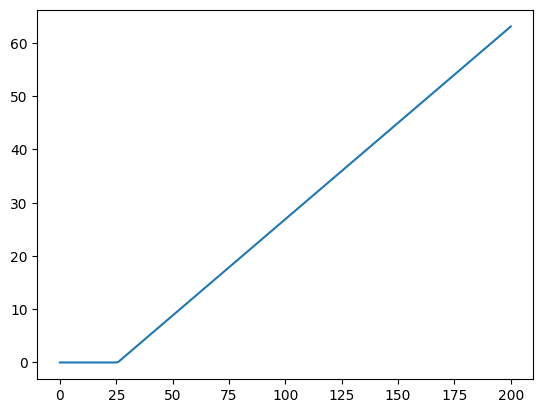

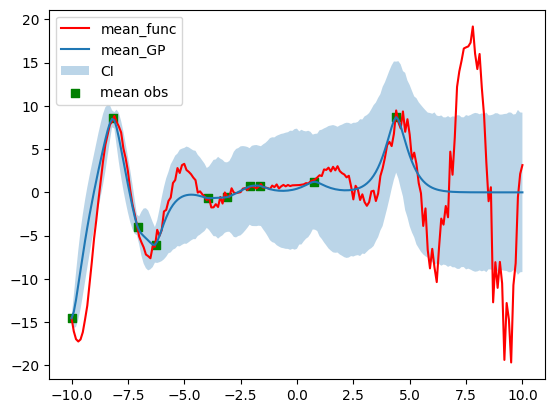

In [ ]:
X_test =xs
X_test = np.reshape(X_test,(X_test.shape[0],1))
X_test_full = xs
X_test_full = np.reshape(X_test_full,(X_test_full.shape[0],1))
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Calculate mean values of the measured samples
train_ym = np.mean(train_y, axis=1)
# Calculate noise of the measured samples
train_noise = np.absolute(np.std(train_y, axis =1))**2
train_noise = train_noise*10 #Scalling to validate (Dont need for real implementation)
# Initialize MF model
gp_model = MeasuredNoiseGP(1, kernel='RBF')
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_ym, train_noise)



y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, train_x, train_noise)
plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(xs, y_pred, label="mean_GP")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
plt.scatter(train_x, train_ym, c="g", marker="s", label="mean obs")

plt.legend(loc="best")
plt.show()

We can see the GP prediction is noisier for the sampled refion in the right as we know from the ground truth function

Run BO- 25 iterations (Need to customize the acq function in Gpax)

Step:1


sample: 100%|██████████| 4000/4000 [00:08<00:00, 488.08it/s, 7 steps of size 6.24e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.56      0.25      0.54      0.14      0.92   1120.79      1.00
    k_scale     24.56     10.39     22.11     11.15     39.16    941.30      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan

8.49946124711387
7.991316743881372
7.564024884929552
7.18103316427998
6.83773463162916
6.530015484799481
6.254188283920072
6.0069477545971415
5.785331180361565
5.586682900039517
5.408622484607953
5.249016212193917
5.105951499398751
4.977713982554377
4.862766974273193
4.759733049116725
4.667377537721598
4.58459373159073
4.51038962125677
4.443876008899422
4.384255852968534
4.330814717128152
4.28291220906996
4.239974306606233
4.201486479084864
4.166987521699463
4.136064028810215
4.108345440048573
4.083499599842589
4.061228777152098
4.041266097717657
4.023372346070469
4.007333098981284
3.992956155998037
3.9800692362820316
3.9685179141435003
3.9581637685378293
3.9488

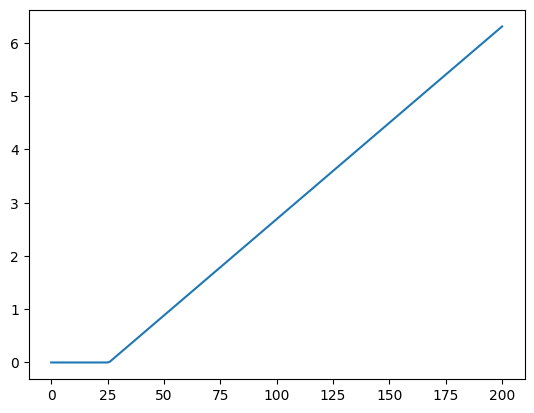

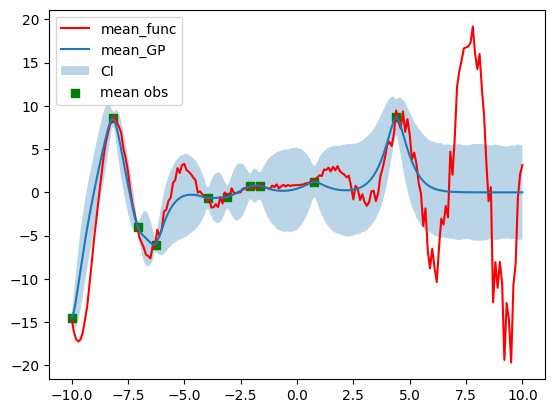

TypeError: ignored

In [ ]:
N = 25
X_test =xs
X_test = np.reshape(X_test,(X_test.shape[0],1))
X_test_full = xs
X_test_full = np.reshape(X_test_full,(X_test_full.shape[0],1))
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

for i in range(1, N+1):
    print("Step:"+str(i))

    # Calculate mean values of the measured samples
    train_ym = np.mean(train_y, axis=1)
    # Calculate noise of the measured samples
    train_noise = np.absolute(np.std(train_y, axis =1))**2
    train_noise = train_noise*10 #Scalling to validate (Dont need for real implementation)
    # Initialize MF model
    gp_model = MeasuredNoiseGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_ym, train_noise)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, train_x, train_y)
        plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        plt.plot(xs, y_pred, label="mean_GP")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI",
        )
        plt.scatter(train_x, train_ym, c="g", marker="s", label="mean obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    next_point_idx = acq.argmax()
    next_point_val = acq.max()
    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        np.random.seed(10)
        tr_y = np.zeros((1, n_measurement))
        for i in range(n_measurement):
          t_y = objective(train_x[-1], lb, ub)
          tr_y[0, i] = t_y
        train_y = np.vstack((train_y, tr_y))


Step:1


sample: 100%|██████████| 4000/4000 [00:06<00:00, 651.49it/s, 15 steps of size 3.24e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.58      0.23      0.60      0.21      0.95    702.20      1.00
    k_scale     28.44     11.27     25.83     12.91     43.50    813.75      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan

8.49946124711387
7.991316743881372
7.564024884929552
7.18103316427998
6.83773463162916


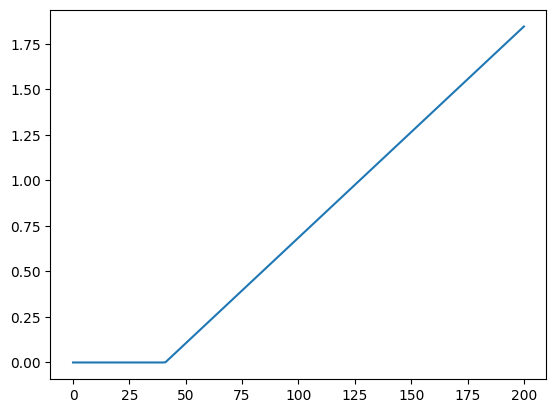

(2000, 1, 201)


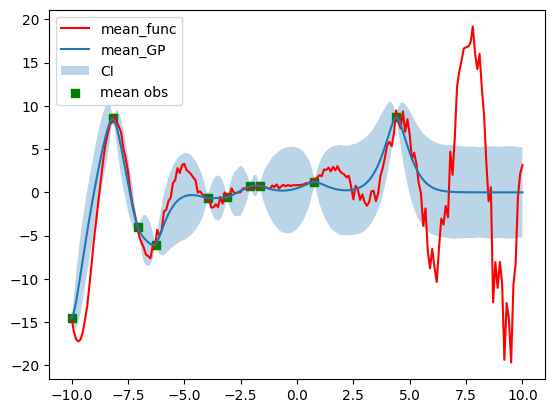

TypeError: ignored

In [ ]:
N = 25
X_test =xs
X_test = np.reshape(X_test,(X_test.shape[0],1))
X_test_full = xs
X_test_full = np.reshape(X_test_full,(X_test_full.shape[0],1))
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

for i in range(1, N+1):
    print("Step:"+str(i))

    # Calculate mean values of the measured samples
    train_ym = np.mean(train_y, axis=1)
    # Calculate noise of the measured samples
    train_noise = np.absolute(np.std(train_y, axis =1))**2
    # Initialize MF model
    gp_model = MeasuredNoiseGP(1, kernel='RBF')
    # Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
    gp_model.fit(rng_key, train_x, train_ym, train_noise)


    if ((i == 1) or ((i % 1) == 0)): # Check predictions after every 5 BO runs
        y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, train_x, train_y)
        plt.plot(xs, ys.mean(axis=1), c="r", label="mean_func")
        pred_lower = y_pred - y_sampled.std(axis=(0,1))
        pred_upper = y_pred + y_sampled.std(axis=(0,1))
        plt.plot(xs, y_pred, label="mean_GP")
        plt.fill_between(
            xs.flatten(),
            pred_lower,
            pred_upper,
            alpha=0.3,
            label="CI",
        )
        plt.scatter(train_x, train_ym, c="g", marker="s", label="mean obs")

        plt.legend(loc="best")
        plt.show()
    # Compute the MF acq function - EI based
    acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    next_point_idx = acq.argmax()
    next_point_val = acq.max()
    # acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=True, noiseless=True)
    # acq = gpax.acquisition.UCB(rng_key_predict, gp_model, X_test, beta=4, maximize=True, noiseless=True)
    if next_point_val == 0:
        print("Model sufficiently learned")
        break
    else:
        next_point = X_test[next_point_idx]
        train_x = np.vstack((train_x, next_point))
        #print(next_point_idx, next_point, next_point_norm, train_x_full, train_x_full_norm)
        np.random.seed(10)
        tr_y = np.zeros((1, n_measurement))
        for i in range(n_measurement):
          t_y = objective(train_x[-1], lb, ub)
          tr_y[0, i] = t_y
        train_y = np.vstack((train_y, tr_y))
